In [1]:
import numpy as np

from pykeen.datasets import OpenBioLink

from pykeen.triples import TriplesFactory
from Bio import Entrez
from tqdm import tqdm
import pandas as pd
import gseapy as gp

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

/nfs_home/users/mbvk/.conda/envs/GNN_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gene_sets = gp.get_library_name("Human")

In [2]:
model= 'RotatE'

In [3]:
entity_embeddings = np.load(f"../../link_prediction/generate_models/entity_embedding_{model}_10models.npy")

In [ ]:
dataset = 'Hetionet'
size = 'large'

In [4]:
train = np.loadtxt(
    f"../../data/{dataset}/{size}/{dataset}_training_{size}.csv",
    dtype=str,
    delimiter=",",
)
train = TriplesFactory.from_labeled_triples(train)

In [5]:
df = pd.read_csv("../../data/IR_GeneID_names.csv")
IR_genes = df["Input ID"]

In [6]:
IR_genes

0       ABCA1
1       ABCB1
2      ABCB11
3       ABCG2
4       ABCG5
        ...  
619      YBX1
620     YWHAZ
621     ZBED3
622    ZFAND3
623    ZFAND6
Name: Input ID, Length: 624, dtype: object

In [7]:
arr_mean = np.mean(entity_embeddings, axis=0)

In [8]:
data = OpenBioLink()

In [9]:
names = train.entity_to_id

In [10]:
def get_gene_names(gene_ids):
    Entrez.email = "ENTER EMAIL HERE"  # Provide your email address to NCBI
    handle = Entrez.esummary(db="gene", id=",".join(gene_ids))
    result = Entrez.read(handle, validate=False, escape=True)
    handle.close()

    gene_names = []
    for docsum in result["DocumentSummarySet"]["DocumentSummary"]:
        if "Name" in docsum:
            gene_names.append(docsum["Name"])

    return gene_names

In [11]:
new_dict = {key.split("::")[1]: value for key, value in names.items() if "Gene:" in key}

In [12]:
keys = list(names.keys())

In [13]:
indices = list(new_dict.values())

In [14]:
new_arr = np.real(np.take(arr_mean, indices, axis=0))

In [15]:
new_arr.shape

(19145, 200)

In [16]:
ncbi_ids = [element.split("::")[1] for element in keys if "Gene" in element]

In [17]:
def get_gene_info(gene_ids):
    Entrez.email = "ENTER EMAIL HERE"
    handle = Entrez.esummary(db="gene", id=",".join(gene_ids))
    result = Entrez.read(handle, validate=False)
    handle.close()

    return result["DocumentSummarySet"]["DocumentSummary"]


gene_list = []
# process IDs in batches of 100
batch_size = 1000

for i in tqdm(range(0, len(ncbi_ids), batch_size)):
    batch_ids = ncbi_ids[i : i + batch_size]
    gene_names = [x["Name"] for x in get_gene_info(batch_ids)]
    gene_list.extend(gene_names)
    # do something with gene_names

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


In [18]:
result_dict = {key: value for key, value in zip(gene_list, ncbi_ids)}

In [19]:
result_dict = {key: result_dict[key] for key in IR_genes if key in result_dict}

In [20]:
result_dict = {key: "Gene::" + value for key, value in result_dict.items()}

In [21]:
result_dict2 = {
    key: names[value] for key, value in result_dict.items() if value in names
}

In [22]:
arr_pos = list(result_dict2.values())

In [23]:
sorted_dict = OrderedDict(sorted(result_dict2.items()))

In [24]:
arr_pos = list(sorted_dict.values())

In [25]:
IR_array = np.array([arr_mean[row] for row in arr_pos])

In [26]:
real_embeddings = np.real(IR_array)
imag_embeddings = np.imag(IR_array)

In [27]:
IR_array = np.column_stack((real_embeddings, imag_embeddings))

In [37]:
# select the keys using the list of positions
selected_keys0 = [list(sorted_dict.keys())[i] for i in positions["0"]]
selected_keys1 = [list(sorted_dict.keys())[i] for i in positions["1"]]
selected_keys2 = [list(sorted_dict.keys())[i] for i in positions["2"]]

In [38]:
go_results = gp.enrichr(
    gene_list=selected_keys0, gene_sets="GO_Biological_Process_2018", organism="Human"
)
go_results_1 = gp.enrichr(
    gene_list=selected_keys1, gene_sets="GO_Biological_Process_2018", organism="Human"
)

In [ ]:
IR_OBL = np.load("PCA_OBL_array.npy")


Text(0.5, 1.0, 'Enriched Functional Processes for Gene List 2')

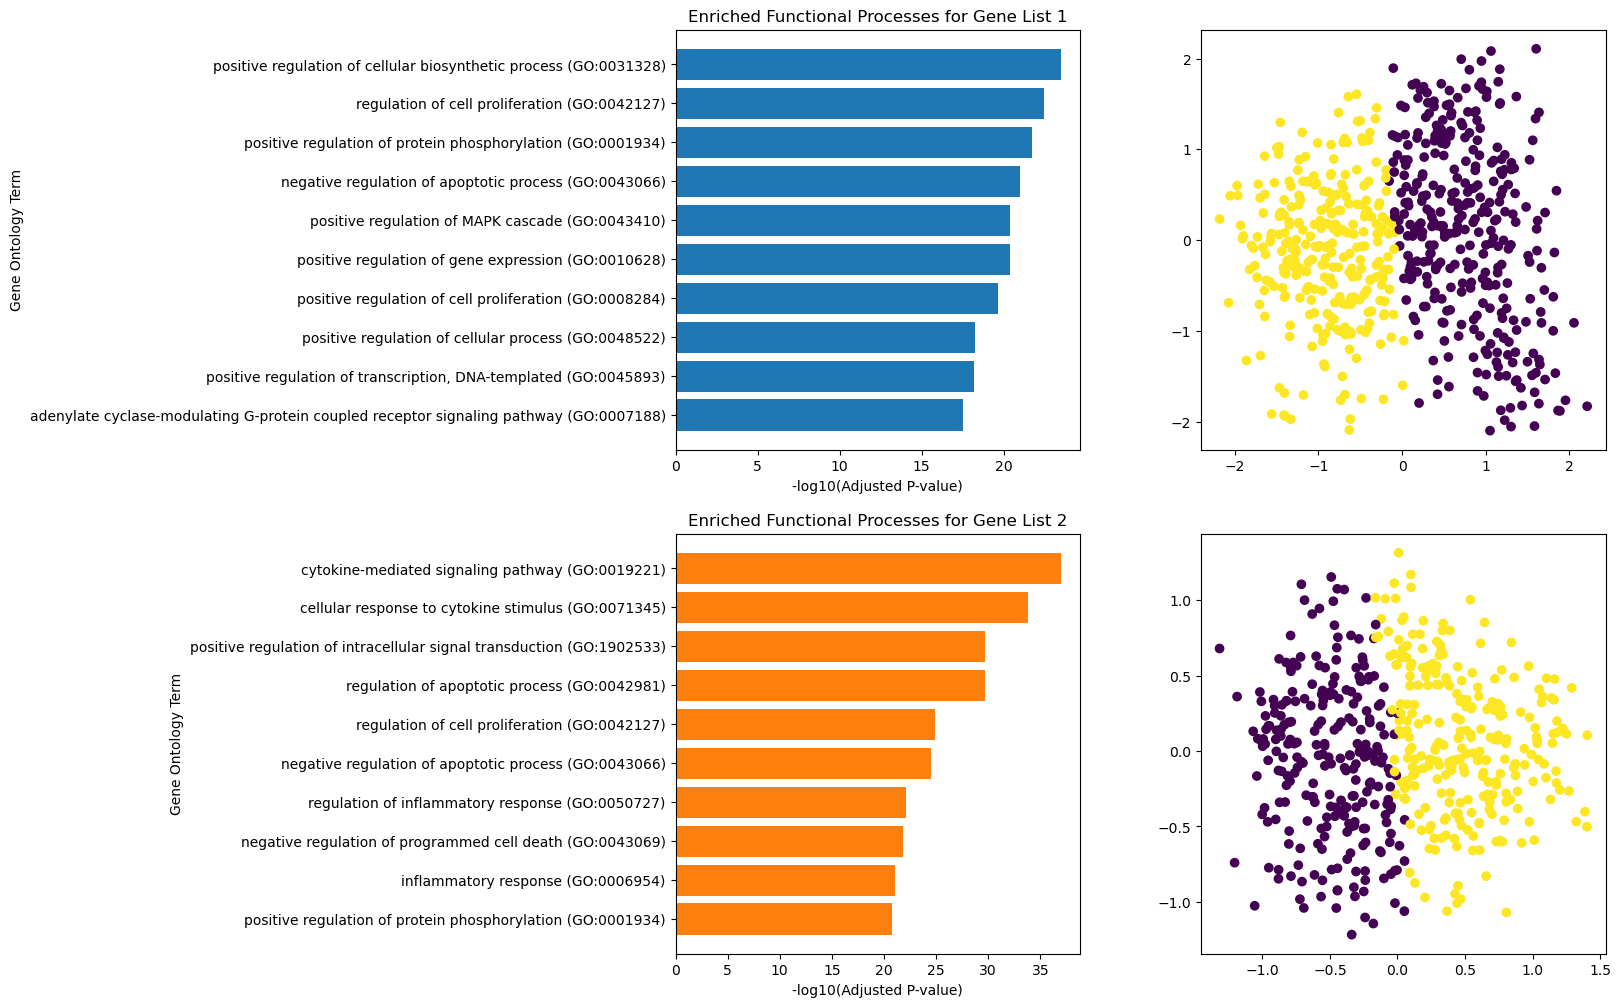

In [118]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

plt.subplots_adjust(wspace=0.3)

ax1.scatter(IR_OBL[:, 0], IR_OBL[:, 1], c=labels_OBL)
ax3.scatter(IR_pca[:, 0], IR_pca[:, 1], c=labels)
# Plot the first gene list on the top
ax0.barh(terms0, -1 * np.log10(pvals0), color="tab:blue")

ax0.set_xlabel("-log10(Adjusted P-value)")
ax0.set_ylabel("Gene Ontology Term")
ax0.set_title("Enriched Functional Processes for Gene List 1")

# Plot the second gene list on the bottom
ax2.barh(terms1, -1 * np.log10(pvals1), color="tab:orange")
ax2.set_xlabel("-log10(Adjusted P-value)")
ax2.set_ylabel("Gene Ontology Term")
ax2.set_title("Enriched Functional Processes for Gene List 2")